In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from scipy import stats
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW
import astropy.units as u

In [108]:
datasets = glob.glob('./unassociated/*.csv')

In [110]:
library = {}
for file in datasets:
    library[file] = pd.read_csv(file, header=None)

In [111]:
    
def reformat_datasets(library):
    reformat = {}

    for key in library:

        d = library[key]
        x = []
        y = []
        yerr = []
        for i in range(d.shape[0]):
            if i % 2:
                yerr.append(d.iloc[i,1])
            else:
                x.append(d.iloc[i,0])
                y.append(d.iloc[i,1])

        yerr = np.abs(np.array(y) - np.array(yerr))

        reformat[key] = pd.DataFrame( {'MJD':x, 'Fl (E>100MeV)e-8 cm-2 s-1':y, 'Error':yerr} )

    return reformat
    
library = reformat_datasets(library)


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power

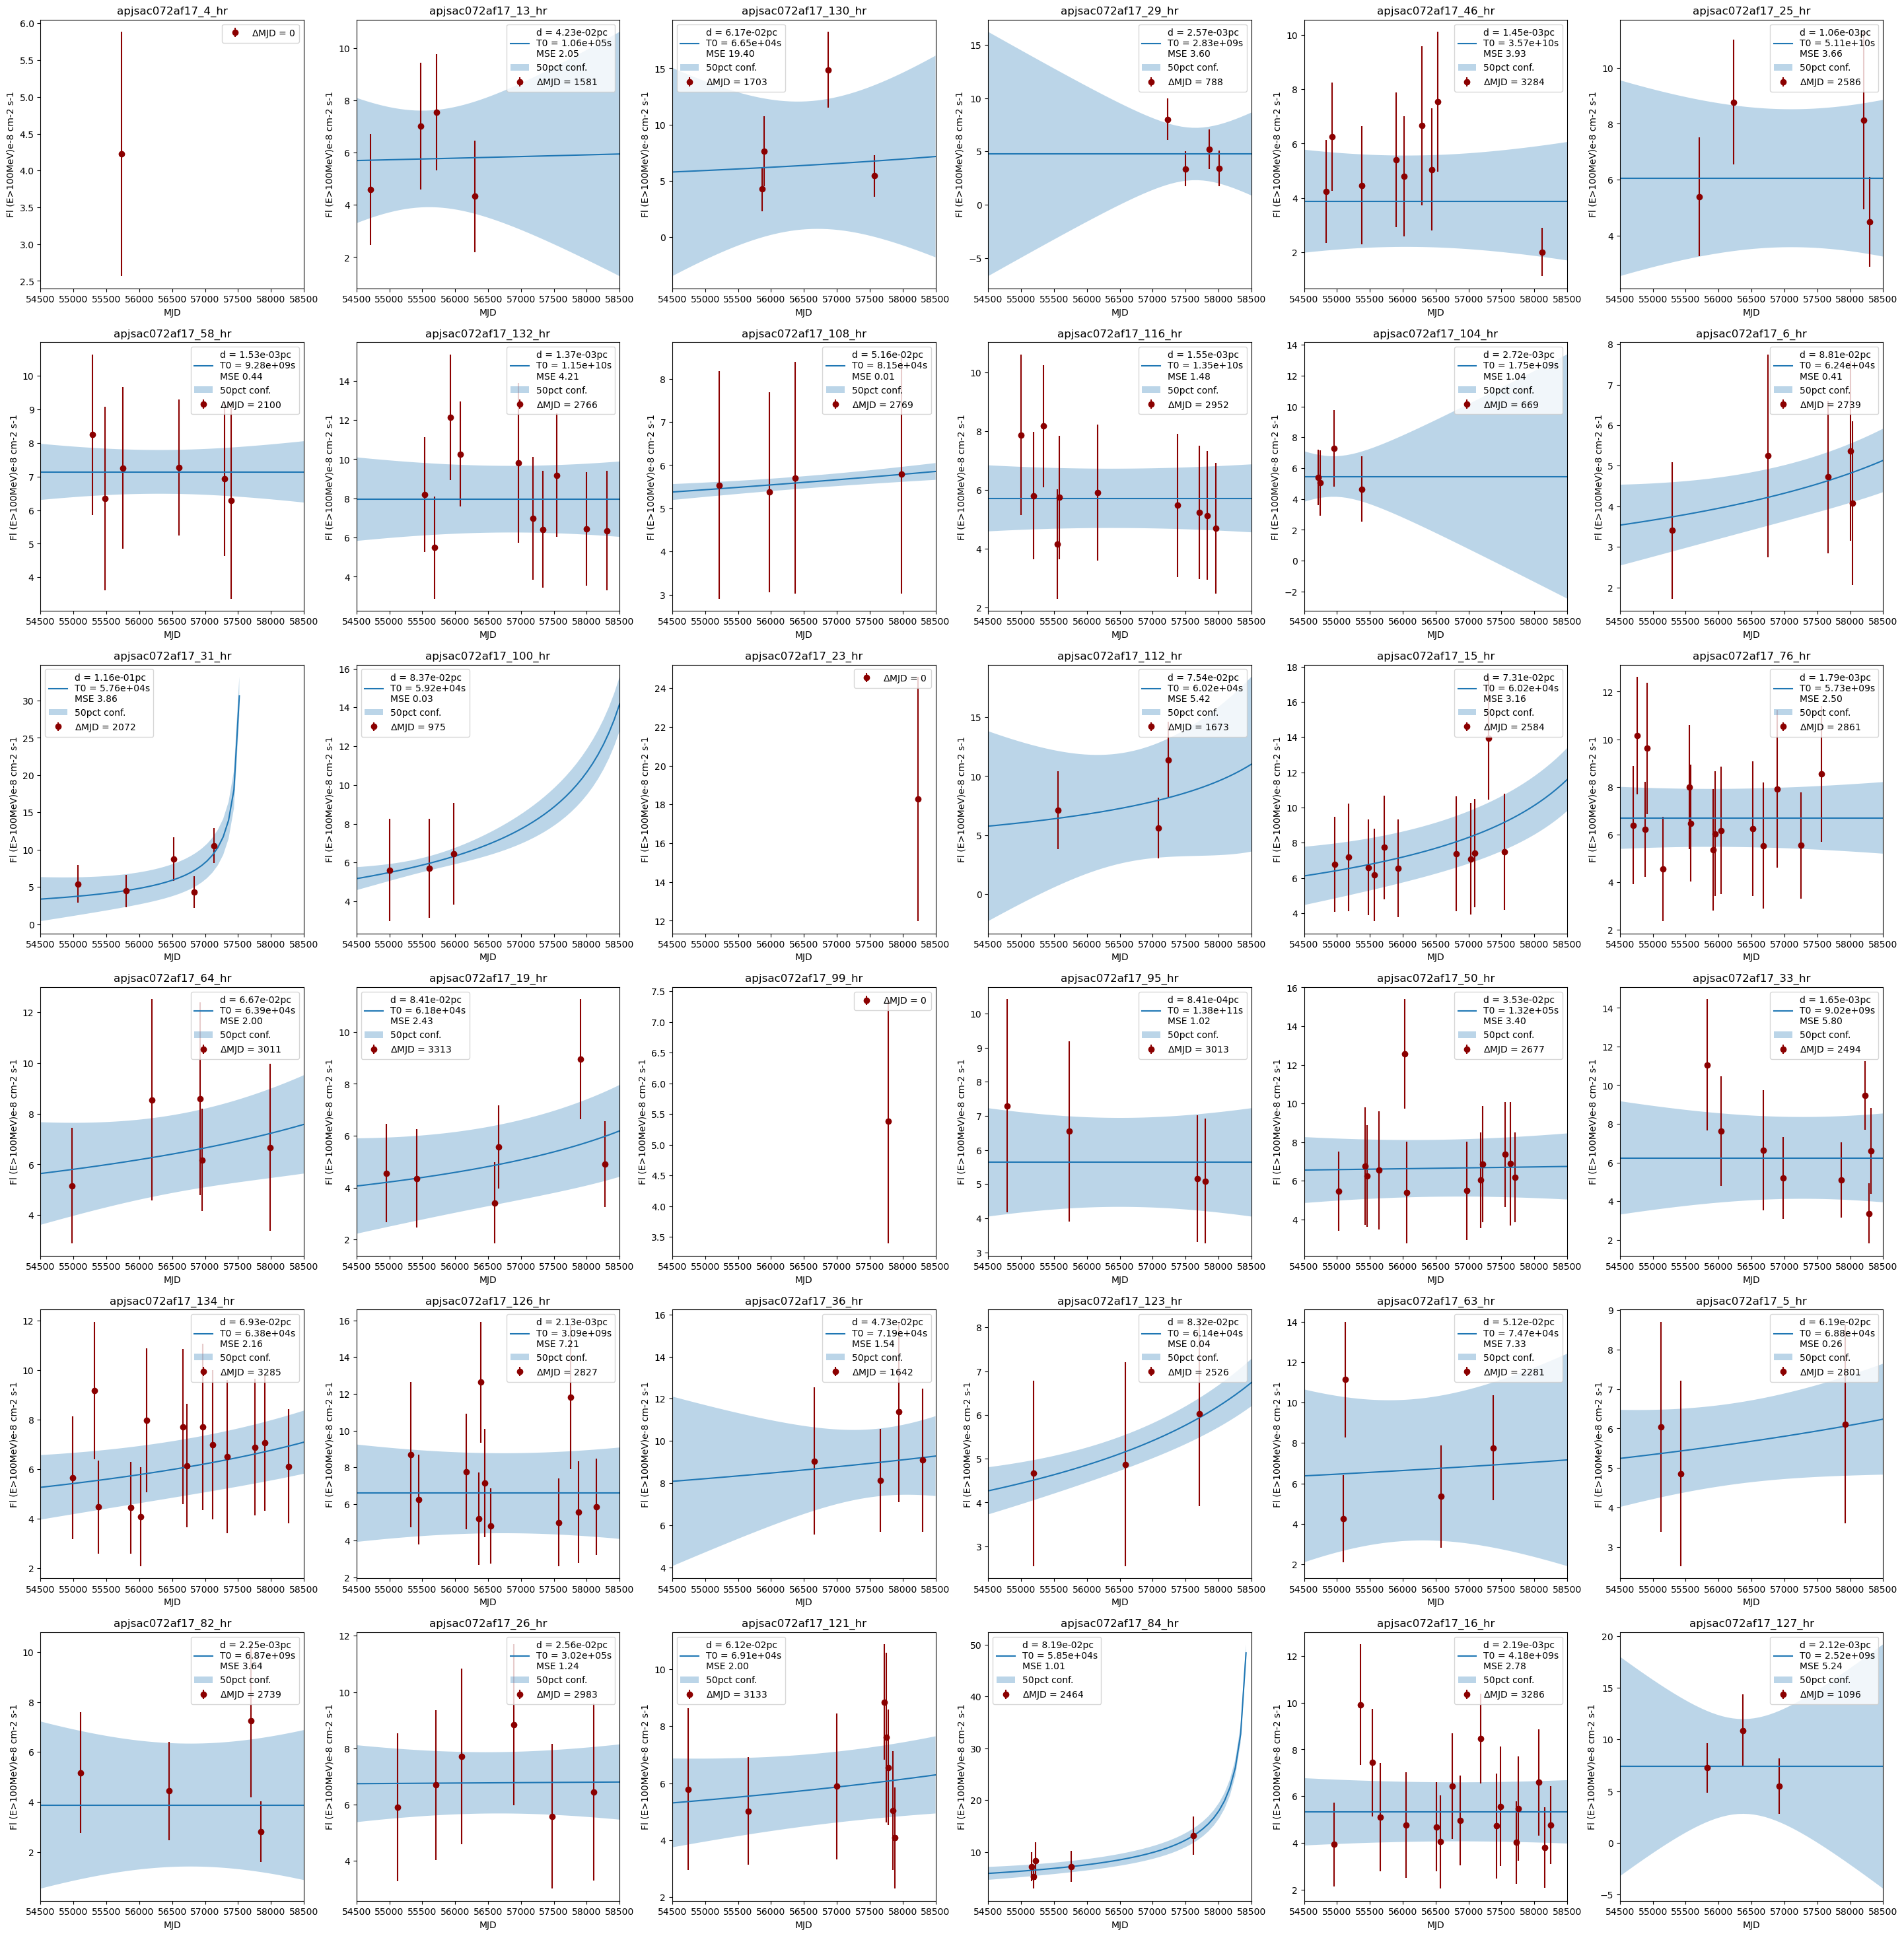

In [255]:
# model = lambda x,A,T0: A * (T0 - x)**(-.53) #lambda x,m,b: m*x + b
model = lambda x,A,T0: 10**A * (10**T0 - x)**(-.53)

fig, axes = plt.subplots(6,6, figsize=(36,37))
ax = axes.flatten()

fit_results = {}

for i,key in enumerate(library):

    d = library[key]

    x = d['MJD']
    y = d['Fl (E>100MeV)e-8 cm-2 s-1']
    yerr = d['Error']

    # Plot datapoints
    ax[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred', label = r'$\Delta$MJD = %i'%(x.iloc[-1] - x.iloc[0]))
    
    # Curve fitting
    if x.shape[0]>1: # If there's >1 datapoint
        coefs, cov = curve_fit(f = model, xdata = x, ydata = y, sigma = yerr, p0 = [
            3, 5#(y.iloc[-1] - y.iloc[0])/(x.iloc[-1] - x.iloc[0]), # slope
            #(x.iloc[0]) # intercept
        ], bounds = (
            [2, 4], # lower bounds
            [7, 18]  # upper bounds
        )
        )

        # Plot the data and the fitted curve
        xaxis = np.linspace(54500, 58500)
        y_model = model(xaxis, coefs[0], coefs[1])

        # Calculate distance
        distance_A = lambda A: np.sqrt(3.2 / A)

        ax[i].plot(xaxis, y_model, '-', label = 'd = %.2epc\nT0 = %.2es\nMSE %.2f'%(distance_A(10**coefs[0]), 10**coefs[1], mean_squared_error(y, model(x, *coefs))))

        # Compute std for each coef
        a_err, b_err = 10**np.sqrt(np.diag(cov))

        # Compute the confidence interval for the fitted curve
        n = len(y)
        p = len(coefs)
        dof = max(0, n - p)  # degrees of freedom
        t = stats.t.ppf(0.5 / 2., dof) # 50% confidence interval

        # Sample standard deviation 
        s_err = np.sqrt(
            np.sum((y - model( x, *coefs )) ** 2) / dof
            )

        # https://www.scribbr.com/statistics/confidence-interval/
        # https://tomholderness.wordpress.com/2013/01/10/confidence_intervals/
        y_fit_upper = y_model + t * s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        y_fit_lower = y_model - t * s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

        ax[i].fill_between(xaxis, y_fit_lower, y_fit_upper, alpha=0.3, label='50pct conf.')

        fit_results[key] = {'Coefs':10**coefs, 'Cov':10**cov}

    ax[i].set_xlim(54500, 58500)

    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    ax[i].set_title(key.split('/')[-1].split('.')[0])
    ax[i].legend()


# fig.savefig('TransientSourceFits_T0>>DeltaT.png', dpi=500)
# fig.savefig('TransientSourceFits_T0>>DeltaT_lowres.png')
fig.savefig('TransientSourceFits_logsFit.png')

In [242]:
def remaining_mass(T0, 
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s
    ):
    """
    Input T0 in seconds;
    return mass in grams
    """
    return (3 * alpha * T0)**(1/3) # Eqn. 7 of Nature article

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'label'


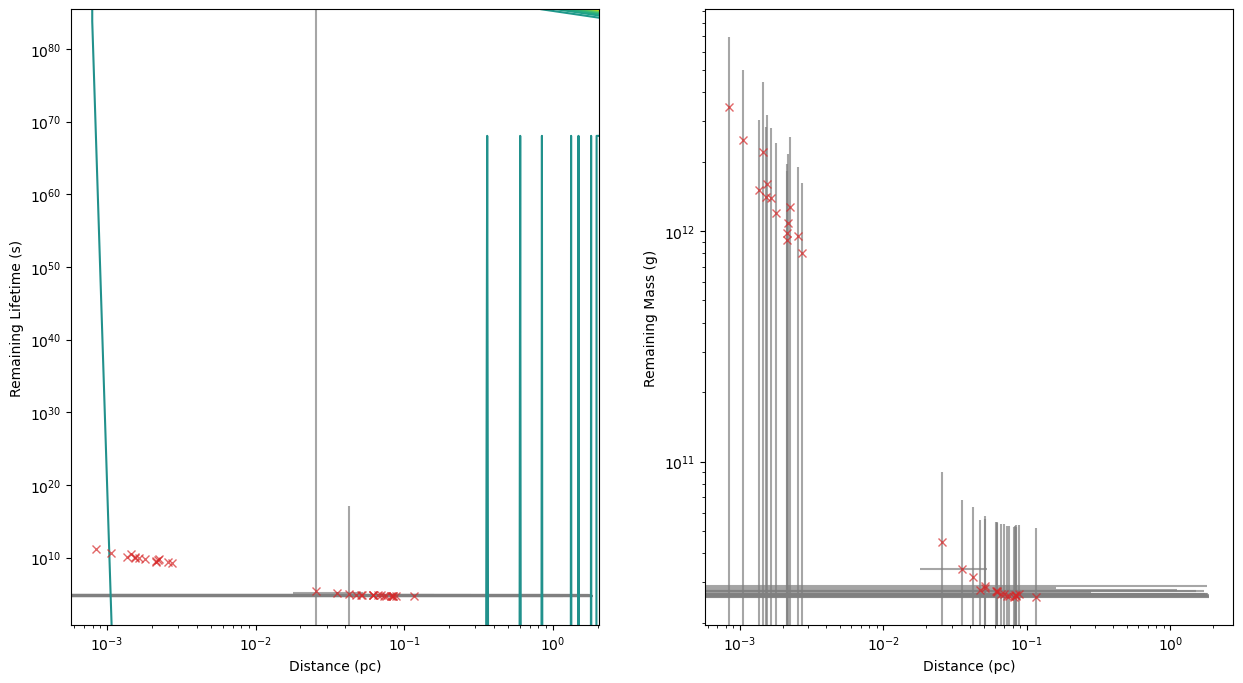

In [292]:
fig, axes = plt.subplots(1,2, figsize = (15,8))

ax = axes[0]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))

    d = distance_A(A)
    d_std = distance_A(A_std)
    ax.errorbar(y = T0, yerr = T0_std, x = d, xerr = d_std, fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.7)


yrange = np.linspace(*ax.get_ylim())
xrange = np.linspace(*ax.get_xlim())
X,Y = np.meshgrid(xrange, yrange)
lim = lambda X,Y: (4/3/3.14159) * 3400 * (X)**3 * (Y/3e7)
# lim_T0 = lambda yrange: (4/3/3.14159) * 3400 * (yrange/3e7)
# lim_dist = lambda xrange: (4/3/3.14159) * 3400 * (xrange)**3 * (1/3e7)
# ax.plot(lim_T0(yrange), yrange, '-', label = r'timelime')
# ax.plot(xrange, lim_dist(xrange), '--', label = 'limit')
ax.contour(X,Y,lim(X,Y),30, label = 'Limit')
# ax.legend()

# ax.set_xlabel('Norm (1/pc^2)')
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('Remaining Lifetime (s)')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e4,1e12)

ax = axes[1]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))

    d = distance_A(A)
    d_std = distance_A(A_std)

    mass = remaining_mass(T0)
    mass_std = remaining_mass(T0)
    ax.errorbar(y = mass, yerr = mass_std, x = d, xerr = d_std, fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.7)


ax.set_xlabel('Distance (pc)')
ax.set_ylabel('Remaining Mass (g)')
ax.set_yscale('log')
ax.set_xscale('log')

# fig.savefig('TransientsDistribution.png')